# An Other Dataset (Lung Dataset)

Starting image processing...
Processed image 1/49: CHNCXR_0001_0.png
Processed image 2/49: CHNCXR_0002_0.png
Processed image 3/49: CHNCXR_0003_0.png
Processed image 4/49: CHNCXR_0004_0.png
Processed image 5/49: CHNCXR_0005_0.png
Processed image 6/49: CHNCXR_0006_0.png
Processed image 7/49: CHNCXR_0007_0.png
Processed image 8/49: CHNCXR_0008_0.png
Processed image 9/49: CHNCXR_0009_0.png
Processed image 10/49: CHNCXR_0010_0.png
Processed image 11/49: CHNCXR_0011_0.png
Processed image 12/49: CHNCXR_0012_0.png
Processed image 13/49: CHNCXR_0013_0.png
Processed image 14/49: CHNCXR_0014_0.png
Processed image 15/49: CHNCXR_0015_0.png
Processed image 16/49: CHNCXR_0016_0.png
Processed image 17/49: CHNCXR_0017_0.png
Processed image 18/49: CHNCXR_0018_0.png
Processed image 19/49: CHNCXR_0019_0.png
Processed image 20/49: CHNCXR_0020_0.png
Processed image 21/49: CHNCXR_0021_0.png
Processed image 22/49: CHNCXR_0022_0.png
Processed image 23/49: CHNCXR_0023_0.png
Processed image 24/49: CHNCXR_0024_0.

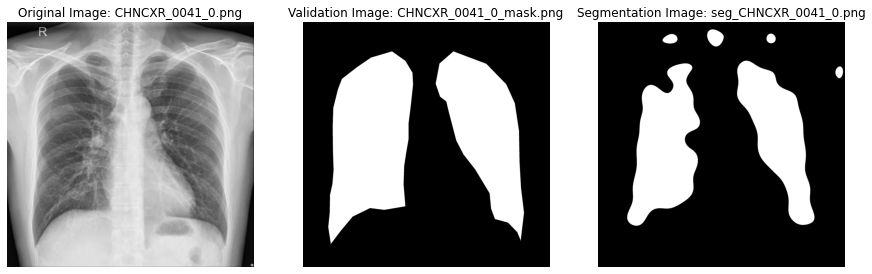


Processing completed. Results saved in lung\segmentation


In [32]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

def process_lung_images():
    # Get list of all images in original directory
    original_files = set(f for f in os.listdir(original_dir) if f.endswith(('.tif', '.png', '.jpg', '.jpeg')))
    validation_files = sorted(f for f in os.listdir(validation_dir) if f.endswith(('.tif', '.png', '.jpg', '.jpeg')))

    # Create a mapping of validation files without '_mask'
    validation_file_map = {f.replace('_mask', ''): f for f in validation_files}

    # Keep only the common images between original and validation folders
    common_files = sorted(original_files.intersection(validation_file_map.keys()))
    total_images = len(common_files)

    if total_images == 0:
        print("No matching images found between original and validation folders.")
        return

    validation_metrics = []
    best_prob1 = float('inf')  # Initialize to infinity
    best_index = -1  # To track the index of the best image

    for idx, filename in enumerate(common_files, 1):
        input_path = os.path.join(original_dir, filename)
        output_path = os.path.join(segmented_dir, f'seg_{filename}')
        
        image = cv2.imread(input_path)
        if image is None:
            print(f"Error loading {input_path}")
            continue
            
        preprocessed = preprocess_image(image)
        segmentation = segment_image(preprocessed)
        smoothed = smooth_contours(segmentation)
        
        cv2.imwrite(output_path, smoothed)

        # Calculate validation metrics
        val_image_path = os.path.join(validation_dir, validation_file_map[filename])
        Prob1, Prob2, ProbErr = calculate_error_probabilities(output_path, val_image_path)
        
        if Prob1 is not None:
            validation_metrics.append((Prob1, Prob2, ProbErr))
            
            # Check for the best avg_Prob1
            if Prob1 < best_prob1:
                best_prob1 = Prob1
                best_index = idx - 1  # Store the index of the best image
        
        print(f"Processed image {idx}/{total_images}: {filename}")

    # Calculate average validation metrics
    if validation_metrics:
        avg_Prob1 = np.mean([m[0] for m in validation_metrics])
        avg_Prob2 = np.mean([m[1] for m in validation_metrics])
        avg_ProbErr = np.mean([m[2] for m in validation_metrics])
        
        print(f"\nAverage Results:")
        print(f"avg_Prob1: {avg_Prob1:.4f}, avg_Prob2: {avg_Prob2:.4f}, avg_ProbErr: {avg_ProbErr:.4f}")

        # Show the best result images
        if best_index != -1:
            best_filename = common_files[best_index]
            best_original_path = os.path.join(original_dir, best_filename)
            best_segmented_path = os.path.join(segmented_dir, f'seg_{best_filename}')
            best_validation_path = os.path.join(validation_dir, validation_file_map[best_filename])

            # Read the best images
            best_original = cv2.imread(best_original_path, cv2.IMREAD_GRAYSCALE)
            best_segmented = cv2.imread(best_segmented_path, cv2.IMREAD_GRAYSCALE)
            best_validation = cv2.imread(best_validation_path, cv2.IMREAD_GRAYSCALE)

            # Plot the images using Matplotlib
            plt.figure(figsize=(15, 5))

            # Original image
            plt.subplot(1, 3, 1)
            plt.imshow(best_original, cmap='gray')
            plt.title(f'Original Image: {os.path.basename(best_original_path)}')
            plt.axis('off')

            # Validation image
            plt.subplot(1, 3, 2)
            plt.imshow(best_validation, cmap='gray')
            plt.title(f'Validation Image: {os.path.basename(best_validation_path)}')
            plt.axis('off')

            # Segmentation image
            plt.subplot(1, 3, 3)
            plt.imshow(best_segmented, cmap='gray')
            plt.title(f'Segmentation Image: {os.path.basename(best_segmented_path)}')
            plt.axis('off')

            # Show the plot
            plt.show()

# Run the processing
if __name__ == "__main__":
    if not os.path.exists(original_dir):
        print(f"Error: Original images directory not found at {original_dir}")
    elif not os.path.exists(validation_dir):
        print(f"Error: Validation directory not found at {validation_dir}")
    else:
        print("Starting image processing...")
        process_lung_images()
        print(f"\nProcessing completed. Results saved in {segmented_dir}")
